In [25]:
from pyspark.ml import Pipeline
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.tree import RandomForest
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import NGram,HashingTF, Word2Vec, Tokenizer, StringIndexer, CountVectorizer, IDF,IndexToString,StopWordsRemover

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

%matplotlib inline

In [3]:
all_reviews = spark.read.csv('/user/ximanw/data/all_reviews.csv', inferSchema=True, header=True, multiLine = True )
#all_reviews.show(10)

In [4]:
# Remove Puctuation
from pyspark.sql.functions import *
def removePunctuation(column):
    
    return lower(trim(regexp_replace(column,'\\p{Punct}','')))



all_reviews = all_reviews.withColumn("removed_punc",removePunctuation(col('text'))) \
                         .withColumn('review_stars',when(all_reviews.review_stars == 5.0, 1.0)\
                                     .when(all_reviews.review_stars == 1.0, 0.0)
)

In [31]:
all_reviews.show(2)

+--------------------+------------+-------------+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|         business_id|        city|         name|review_count|stars|cool|               date|funny|           review_id|review_stars|                text|useful|        removed_punc|
+--------------------+------------+-------------+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|kxX2SOes4o-D3ZQBk...|Philadelphia|        Zaika|         181|  4.0|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|         1.0|Wow!  Yummy, diff...|     1|wow  yummy differ...|
|BVndHaLihEYbr76Z0...|       Tampa|Mamas Kitchen|         162|  4.5|   0|2014-10-11 16:22:06|    0|OAhBYw8IQ6wlfw1ow...|         1.0|Great place for b...|     0|great place for b...|
+--------------------+------------+-------------+------------+-----+----+------------

In [9]:
# Build the pipeline to tokenize and remove stopwords inside the review text
# tokenize
tokenizer = Tokenizer(inputCol="removed_punc", outputCol="words")

# remove stop words
remover = StopWordsRemover(inputCol= tokenizer.getOutputCol(), outputCol='words_clean')

hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features" )

pipeline = Pipeline(stages=[tokenizer,remover,hashingTF])
all_reviews = pipeline.fit(all_reviews).transform(all_reviews)

In [10]:
# Philadelphia
Philadelphia = all_reviews.filter(all_reviews.city == 'Philadelphia')
Philadelphia.count()

259509

In [19]:
#Tampa
Tampa = all_reviews.filter(all_reviews.city == 'Tampa')
Tampa.count()

143857

In [20]:
# Indianapolis

Indianapolis = all_reviews.filter(all_reviews.city == 'Indianapolis')
Indianapolis.count()


107834

In [21]:
# Nashville

Nashville = all_reviews.filter(all_reviews.city == 'Nashville')
Nashville.count()

153433

In [22]:
# Tucson 

Tucson  = all_reviews.filter(all_reviews.city == 'Tucson')
Tucson.count()

114269

In [ ]:
# For all cities

In [17]:
# Split the review dataset into train and test subsets

X_train, X_test = all_reviews.select('features','review_stars').randomSplit([0.8,0.2],seed=42)
                                                                                     
y_train, y_test = X_train.select('review_stars'), X_test.select('review_stars')  

In [36]:
X_train.show(2)

+--------------------+------------+
|            features|review_stars|
+--------------------+------------+
|      (262144,[],[])|         0.0|
|(262144,[3,14,199...|         1.0|
+--------------------+------------+
only showing top 2 rows



In [38]:
X_test.show(2)

+--------------+------------+
|      features|review_stars|
+--------------+------------+
|(262144,[],[])|         0.0|
|(262144,[],[])|         1.0|
+--------------+------------+
only showing top 2 rows



In [39]:
all_reviews.select('review_stars').distinct().show()

+------------+
|review_stars|
+------------+
|         0.0|
|         1.0|
+------------+



In [42]:
def evaluation(labelCol, predictionCol, predictions):
    evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol=predictionCol)
    print("accuracy:",evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
    print("f1: ", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    print("weightedRecall: ", evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))
    print("weightedPrecision: ", evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}))
    

In [18]:
# Multinomial Naive Bayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol = "features", labelCol ="review_stars")
nb_model = nb.fit(X_train )
nb_prediction = nb_model.transform(X_test)

In [21]:
nb_prediction.printSchema()

root
 |-- features: vector (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
# Create a class to plot the AUC curver
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
    
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)


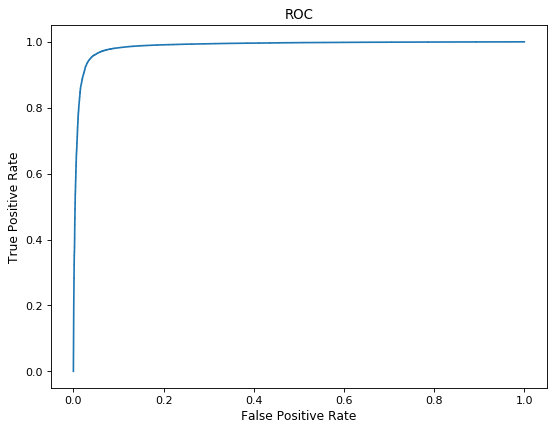

In [39]:
preds = nb_prediction.select('review_stars','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['review_stars'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure(figsize=(8, 6), dpi=80)
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('False Positive Rate', fontsize = 11)
plt.ylabel('True Positive Rate', fontsize = 11)
plt.plot(x_val, y_val)
plt.show()

In [43]:
#evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction")
evaluation('review_stars', "prediction", nb_prediction)

accuracy: 0.9671636606890164
f1:  0.9672522468103059
weightedRecall:  0.9671636606890164
weightedPrecision:  0.9673611229146382


In [47]:
evaluator = MulticlassClassificationEvaluator(labelCol="review_stars", predictionCol="prediction")
evaluator.metricName

Param(parent='MulticlassClassificationEvaluator_f3ba5f5ae4c3', name='metricName', doc='metric name in evaluation (f1|weightedPrecision|weightedRecall|accuracy)')

In [48]:
# Philadelphia

In [23]:
train_df, test_df = Philadelphia.randomSplit([0.8, 0.2])

nb_model = nb.fit(train_df )
nb_prediction = nb_model.transform(test_df)


In [51]:
evaluation('review_stars', "prediction", nb_prediction)

accuracy: 0.9667274997598694
f1:  0.9664646366959624
weightedRecall:  0.9667274997598694
weightedPrecision:  0.9663548993360511


In [50]:
# Tampa

In [52]:
train_df, test_df = Tampa.randomSplit([0.8, 0.2])

nb_model = nb.fit(train_df )
nb_prediction = nb_model.transform(test_df)

print('Tampa')
evaluation('review_stars', "prediction", nb_prediction)

Tampa
accuracy: 0.96492260812355
f1:  0.9643813103675931
weightedRecall:  0.96492260812355
weightedPrecision:  0.9645317074374635


In [ ]:
# Indianapolis

In [53]:
train_df, test_df = Indianapolis.randomSplit([0.8, 0.2])

nb_model = nb.fit(train_df )
nb_prediction = nb_model.transform(test_df)

print('Indianapolis')
evaluation('review_stars', "prediction", nb_prediction)

Indianapolis
accuracy: 0.9604356730590207
f1:  0.9593946236836833
weightedRecall:  0.9604356730590207
weightedPrecision:  0.9599970003218858


In [ ]:
# Nashville  

In [54]:
train_df, test_df = Nashville.randomSplit([0.8, 0.2])

nb_model = nb.fit(train_df )
nb_prediction = nb_model.transform(test_df)

print('Nashville')
evaluation('review_stars', "prediction", nb_prediction)

Nashville
accuracy: 0.9669895945461069
f1:  0.9663256394160968
weightedRecall:  0.9669895945461069
weightedPrecision:  0.9665337437102937


In [54]:
# Tucson 

In [55]:
train_df, test_df = Tucson.randomSplit([0.8, 0.2])

nb_model = nb.fit(train_df)
nb_prediction = nb_model.transform(test_df)

print('Tucson')
evaluation('review_stars', "prediction", nb_prediction)

Tucson
accuracy: 0.9596777724267764
f1:  0.9591027706169757
weightedRecall:  0.9596777724267764
weightedPrecision:  0.9593524481724627


In [15]:
# Define a function to display top words used in reviews

def word_cloud(df,city, star, color):
    review_words = " ".join(word for word in df.removed_punc)
    review_word_cnt = WordCloud(max_words = 300, width = 800, height = 800, min_font_size = 10, background_color = color).generate(review_words) #

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(review_word_cnt)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('{} - {}-star Review Top words'.format(city,star))
 
    plt.show()
    

In [87]:
# Philadelphia

In [11]:
Philadelphia = Philadelphia.orderBy('date', ascending = False)
pos_review = Philadelphia.filter(col('review_stars') == 1.0).limit(10000).toPandas()

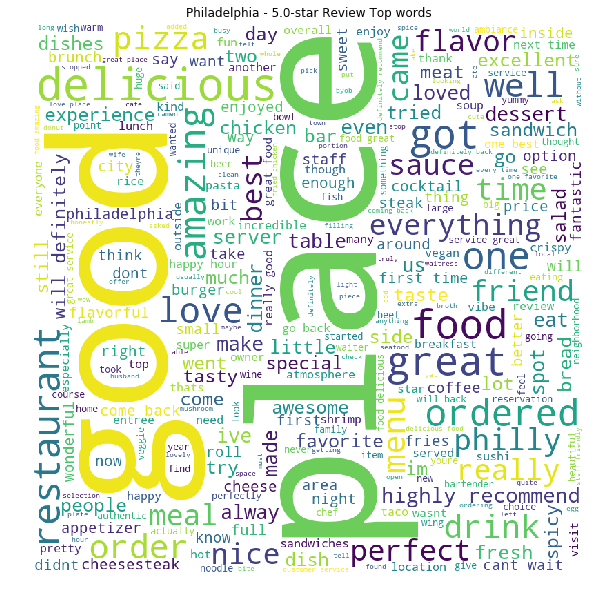

In [84]:
word_cloud(pos_review,'Philadelphia', 5.0, 'white')

In [12]:
neg_review = Philadelphia.filter(col('review_stars') == 0.0).limit(10000).toPandas()

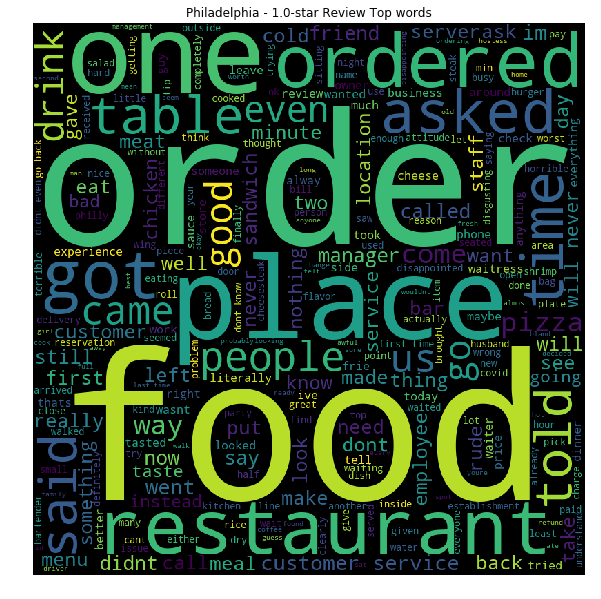

In [16]:
word_cloud(neg_review,'Philadelphia', 1.0, 'black')

In [ ]:
# Tampa

In [71]:
Tampa = Tampa.orderBy('date', ascending = False)
pos_review = Tampa.filter(col('review_stars') == 1.0).limit(10000).toPandas()

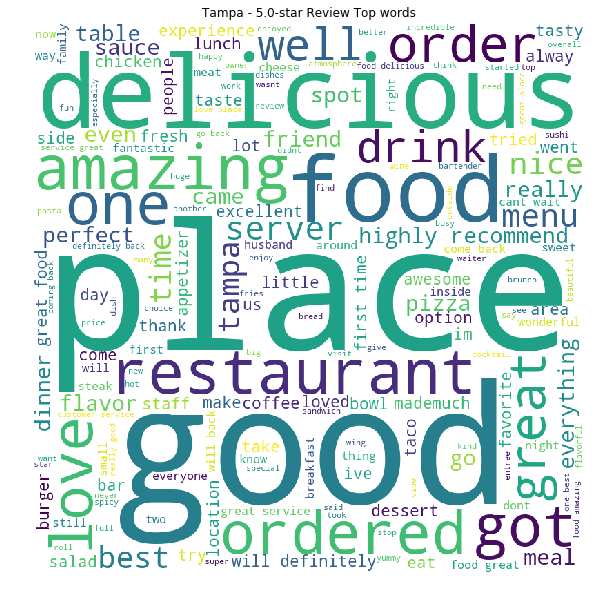

In [81]:
word_cloud(pos_review,'Tampa', 5.0, 'white')

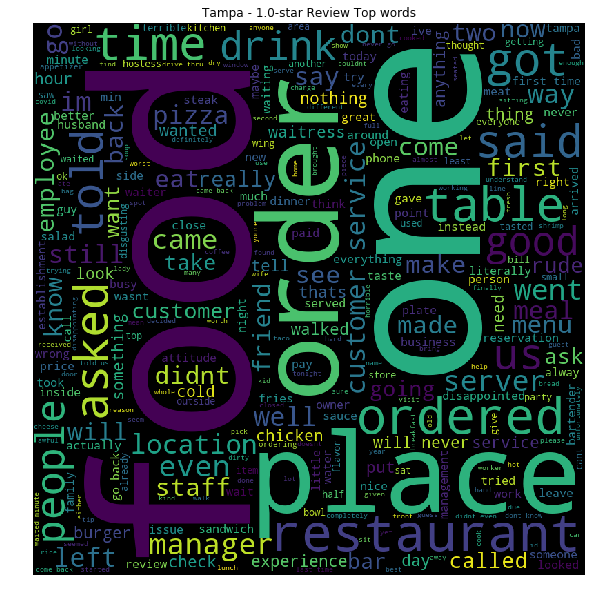

In [82]:
neg_review = Tampa.filter(col('review_stars') == 0.0).limit(10000).toPandas()
word_cloud(neg_review,'Tampa', 1.0, 'black')

In [88]:
# Indianapolis

In [89]:
Indianapolis = Indianapolis.orderBy('date', ascending = False)

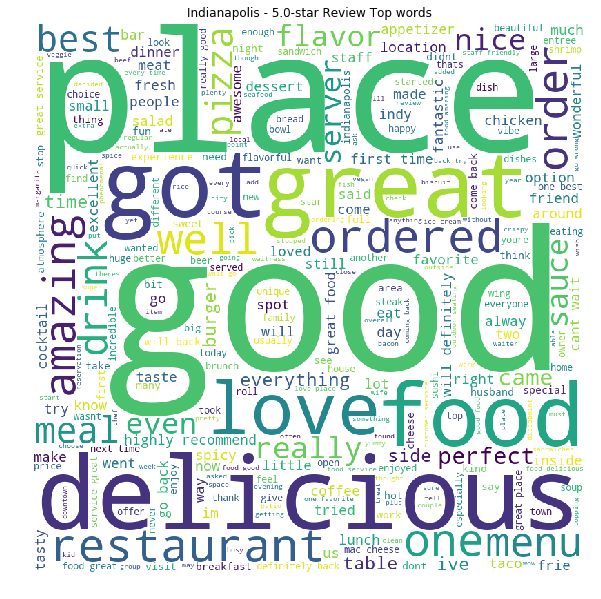

In [90]:
pos_review = Indianapolis.filter(col('review_stars') == 1.0).limit(10000).toPandas()
word_cloud(pos_review,'Indianapolis', 5.0, 'white')

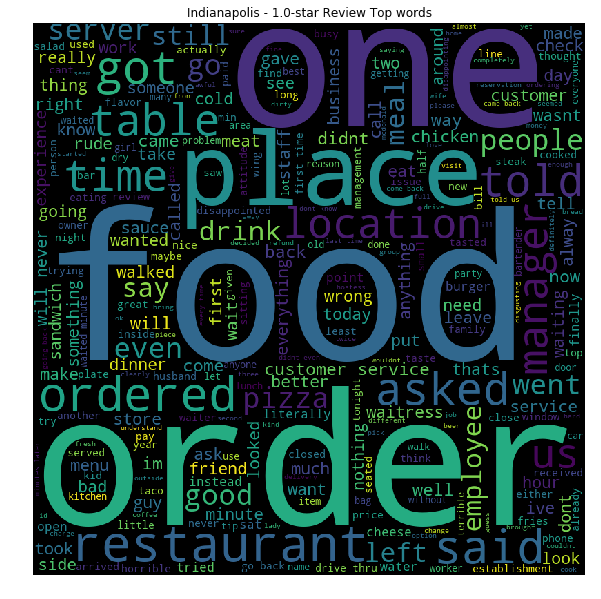

In [91]:
neg_review = Indianapolis.filter(col('review_stars') == 0.0).limit(10000).toPandas()
word_cloud(neg_review,'Indianapolis', 1.0, 'black')

In [ ]:
# Tucson 

In [92]:
Tucson  = Tucson.orderBy('date', ascending = False)

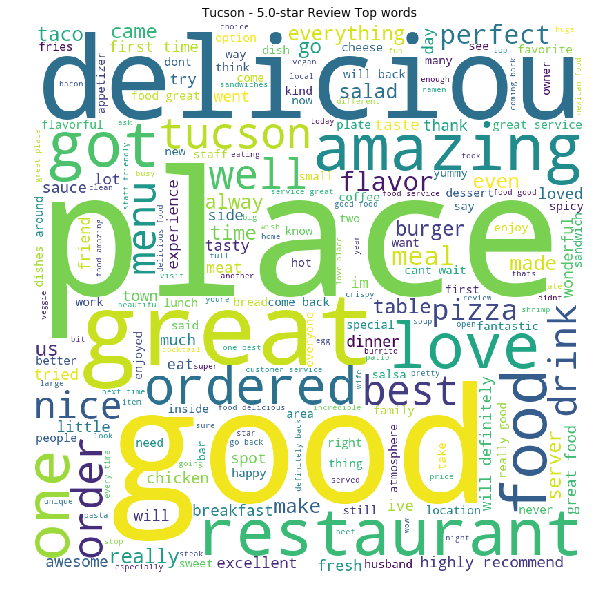

In [93]:
pos_review = Tucson.filter(col('review_stars') == 1.0).limit(10000).toPandas()
word_cloud(pos_review,'Tucson', 5.0, 'white')

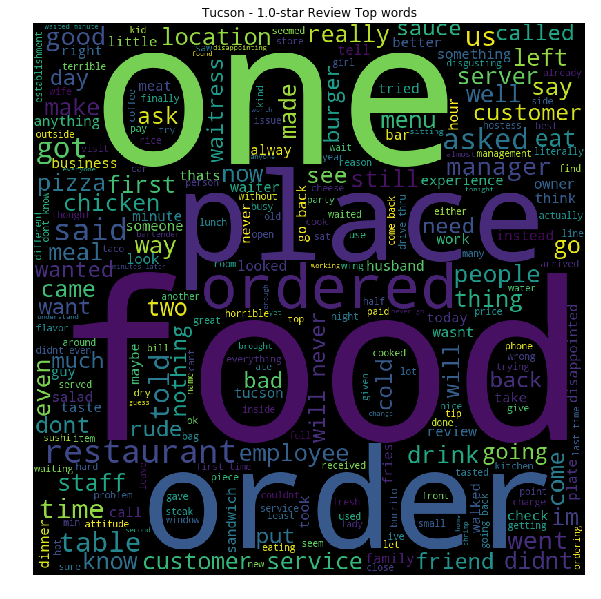

In [94]:
neg_review = Tucson.filter(col('review_stars') == 0.0).limit(10000).toPandas()
word_cloud(neg_review,'Tucson', 1.0, 'black')

In [95]:
Nashville = Nashville.orderBy('date', ascending = False)

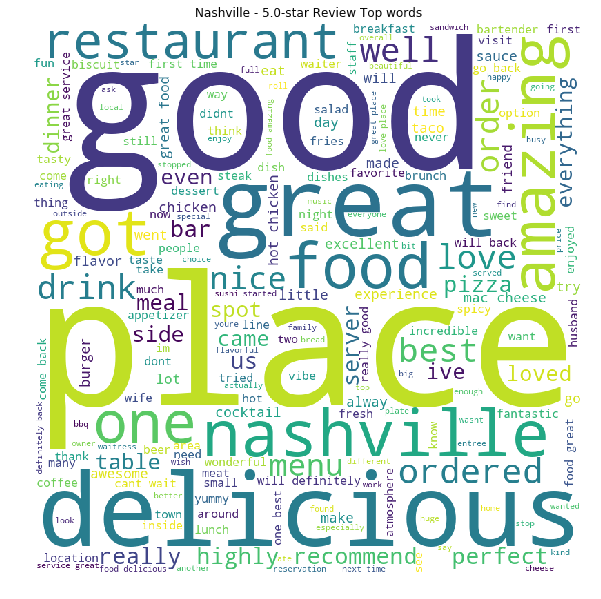

In [96]:
pos_review = Nashville.filter(col('review_stars') == 1.0).limit(10000).toPandas()
word_cloud(pos_review,'Nashville', 5.0, 'white')

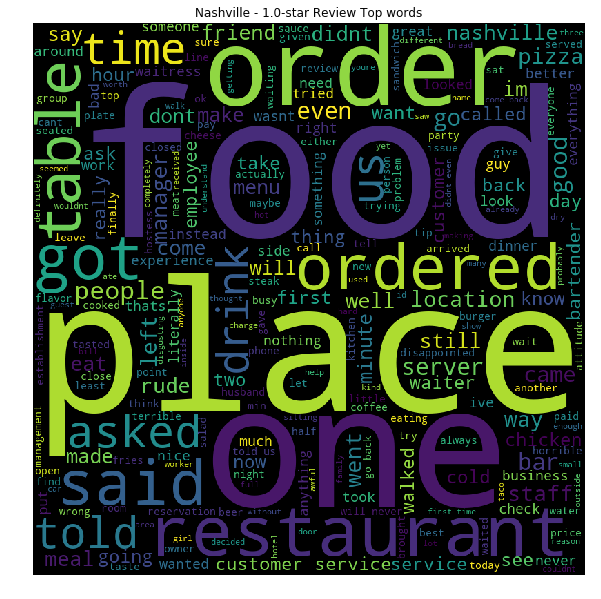

In [97]:
neg_review = Nashville.filter(col('review_stars') == 0.0).limit(10000).toPandas()
word_cloud(neg_review,'Nashville', 1.0, 'black')